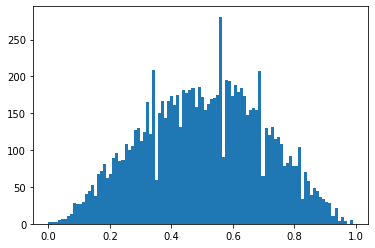

In [1]:
# PPC Round 2

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

normal_dist = lambda x, m, s: 1 / (np.sqrt(2*np.pi) * s) * np.exp(-1/2 * ((x - m) / s)**2)

def b_maxL_2(m, t, C):
    first = C[0]+C[1]-(m[0]+m[1])*(t[0]+t[1])
    root = (C[0]+C[1]+(m[0]-m[1])*(t[0]+t[1]))**2-4*C[0]*(m[0]-m[1])*(t[0]+t[1])
    res = (first+np.sqrt(root))/(2*(t[0]+t[1]))
    if res < 0:
        return 0
    return res

def p_log_prob(b, m, t, C):
    part1_1 = np.log(t[0] * (m[0] + b)) * C[0]
    part1_2 = -t[0] * (m[0] + b)
    res1 = part1_1 + part1_2
    part2_1 = np.log(t[1] * (m[1] + b)) * C[1]
    part2_2 = -t[1] * (m[1] + b)
    res2 = part2_1 + part2_2
    return res1 + res2
    

s1 = 200.
s2 = 1000.
b = 300.
t1 = 1.
t2 = 1.

true_counts = np.array([s1, s2, b, b])
cluster_size = 2

num_samples = 10000
num_trials = 101

num_bins = 100

measured_counts = np.random.poisson(true_counts, (num_samples, len(true_counts)))

available_counts = measured_counts[:,:cluster_size] + measured_counts[:,cluster_size:]

b_max_L = np.zeros(num_samples)
for i in range(num_samples):
    b_max_L[i] = b_maxL_2([s1,s2], [t1, t2], available_counts[i])
    
source_samples = np.random.poisson(s1, (num_samples, num_trials))

naive_background = np.random.poisson(b_max_L, (num_trials, num_samples)).T


naive_total = source_samples + naive_background
argsort = np.argsort(naive_total, axis=1)
naive_total = np.take_along_axis(naive_total, argsort, axis=1)

naive_cdf = np.zeros(num_samples)
for i in range(num_samples):
    naive_cdf[i] = ((np.searchsorted(naive_total[i,:], available_counts[i, 0], "left")
                     + np.searchsorted(naive_total[i,:], available_counts[i, 0], "right"))
                     / (2 * num_trials))
    
_ = plt.hist(naive_cdf, bins=num_bins)

b_samples = np.zeros((num_samples, num_trials))

num_bs = 500
b_range = 4
for i in range(num_samples):
    bs = np.linspace(b_max_L[i]-b_range*np.sqrt(b_max_L[i]), b_max_L[i]+b_range*np.sqrt(b_max_L[i]), num_bs)
    weights = p_log_prob(bs, [s1,s2], [t1,t2], available_counts[i])
    weights -= np.average(weights)
    weights = np.exp(weights)
    weights = weights / np.sum(weights)
    for j in range(num_trials):
        b_samples[i,j] = bs[np.random.choice(num_bs, p=weights)]
        
better_total = b_samples + source_samples
argsort = np.argsort(better_total, axis=1)
better_total = np.take_along_axis(better_total, argsort, axis=1)

better_cdf = np.zeros(num_samples)
for i in range(num_samples):
    better_cdf[i] = ((np.searchsorted(better_total[i,:], available_counts[i, 0], "left")
                     + np.searchsorted(better_total[i,:], available_counts[i, 0], "right"))
                     / (2 * num_trials))
    
# _ = plt.hist(better_cdf, bins=num_bins)

# _ = plt.hist(b_samples.flatten(), bins=num_bins)

# _ = plt.hist(naive_background.flatten(), bins=num_bins)


In [81]:
np.log(np.math.factorial(10))

15.104412573075516

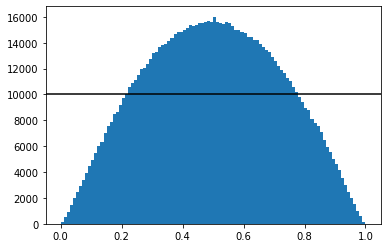

In [3]:
# PPC Distribution Test

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

normal_dist = lambda x, m, s: 1 / (np.sqrt(2*np.pi) * s) * np.exp(-1/2 * ((x - m) / s)**2)

s1 = 200
s2 = 1000
b = 300

true_counts = np.array([s1, s2, b, b])
cluster_size = 2

num_samples = 1000000

# Normal Distribution
measured_counts = np.random.normal(true_counts, np.sqrt(true_counts), (num_samples, len(true_counts)))
# Poisson Distribution
# measured_counts = np.random.poisson(true_counts, (num_samples, len(true_counts)))

# Average b_max_L
b_max_L = b + np.average(measured_counts - true_counts[np.newaxis,:], axis=1) * 2
# True b_max_L
def b_maxL_2(m, t, C):
    first = C[0]+C[1]-(m[0]+m[1])*(t[0]+t[1])
    root = (C[0]+C[1]+(m[0]-m[1])*(t[0]+t[1]))**2-4*C[0]*(m[0]-m[1])*(t[0]+t[1])
    res = (first+np.sqrt(root))/(2*(t[0]+t[1]))
    if res < 0:
        return 0
    return res
for i in range(num_samples):
    b_max_L[i] = b_maxL_2(true_counts[:cluster_size], [1,1], measured_counts[i,:cluster_size] + measured_counts[i,cluster_size:])


std_b = np.sqrt(np.sum(true_counts) / cluster_size**2)
# n, bins, _ = plt.hist(b_max_L, bins=50)
xs = np.linspace(b-3*std_b, b+3*std_b, 100)
ys = normal_dist(xs, b, std_b)
# plt.plot(xs, ys*np.amax(n)/np.amax(ys))
# plt.title("b_max_L")

available_data = np.zeros((num_samples, 2 * cluster_size))
available_data[:,:cluster_size] = np.repeat(true_counts[:cluster_size][np.newaxis,:], num_samples, axis=0)
available_data[:,cluster_size:] = np.repeat(b_max_L[:,np.newaxis], cluster_size, axis=1)

expected_mean_variance = np.sum(np.abs(available_data), axis=1) / (2 * cluster_size)**2
expected_std = np.repeat(2*np.sqrt(expected_mean_variance[:,np.newaxis]), 2*cluster_size, axis=1)
expected_std[:,:cluster_size] = np.sqrt(np.abs(available_data[:,:2]))

expected_counts = available_data[:,:cluster_size] + available_data[:,cluster_size:]
expected_counts_std = np.sqrt(expected_std[:,:cluster_size]**2 + expected_std[:,cluster_size:]**2)

counts = measured_counts[:,:cluster_size] + measured_counts[:,cluster_size:]

num_bins = 100

# Total Counts
cdf = norm.cdf(counts, expected_counts, expected_counts_std)
# _ = plt.hist(cdf[:,1], bins=num_bins)

# Only Background
cdf_background = norm.cdf(measured_counts[:,cluster_size:], available_data[:,cluster_size:], expected_std[:,cluster_size:])
# _ = plt.hist(cdf_background[:,1], bins=num_bins)

# Only Background True Variance
true_data = np.repeat(true_counts[np.newaxis,:], num_samples, axis=0)
true_mean_variance = np.sum(np.abs(true_data), axis=1) / (2 * cluster_size)**2
true_std = np.repeat(2*np.sqrt(true_mean_variance[:,np.newaxis]), 2*cluster_size, axis=1)
true_std[:,:cluster_size] = np.sqrt(np.abs(true_data[:,:cluster_size]))
cdf_background_true = norm.cdf(measured_counts[:,cluster_size:], available_data[:,cluster_size:], true_std[:,cluster_size:])
# _ = plt.hist(cdf_background_true[:,1], bins=num_bins)

# Only Source
cdf_source = norm.cdf(measured_counts[:,:cluster_size], true_data[:,:cluster_size], true_std[:,:cluster_size])
# _ = plt.hist(cdf_source[:,1], bins=num_bins)

# Source and True Background Correlation
z_source = (measured_counts[:,0] - available_data[:,0]) / true_std[:,0]
z_background = (measured_counts[:,2] - available_data[:,2]) / true_std[:,2]
# print(np.corrcoef(z_source, z_background))


# True Correlated
index = 0 # we want b1 given s1
mask = [True] * 2 * cluster_size
mask_no_s = mask.copy()
mask_no_s[index] = False
mask_no_s_b = mask_no_s.copy()
mask_no_s_b[cluster_size+index] = False

true_sig = np.sqrt(np.abs(true_data[:,cluster_size+index]))
true_sig_m_cor = np.sqrt(np.sum(np.abs(true_data[:,mask_no_s]), axis=1)) / len(true_data[0,mask_no_s])
true_sig_m_cor_given_b = np.sqrt(np.sum(np.abs(true_data[:,mask_no_s_b]), axis=1))  / len(true_data[0,mask_no_s])
true_sig_m_given_s = np.sqrt(np.sum(np.abs(true_data[:,mask_no_s]), axis=1))  / len(true_data[0,mask])
beta = (18*true_sig_m_cor**2 - 4*true_sig**2) / (9 * true_sig * true_sig_m_cor * true_sig_m_cor_given_b)

true_sigma = true_sig * true_sig_m_cor_given_b / true_sig_m_cor * np.sqrt(1 + true_sig_m_given_s**2 * beta**2)
true_delta = -1/2

cdf_true_back = norm.cdf(
    measured_counts[:,cluster_size+index],
    available_data[:,cluster_size+index] + true_delta * (measured_counts[:,index] - available_data[:,index]),
    true_sigma
)
# _ = plt.hist(cdf_true_back[:], bins=num_bins)

# True Total Counts
total_std = np.sqrt(true_sigma**2 + true_std[:,index]**2)
total_mean = available_data[:,cluster_size+index] + true_delta * (measured_counts[:,index] - available_data[:,index]) + true_data[:,index]

cdf_true_total = norm.cdf(counts[:,index], total_mean, total_std)
_ = plt.hist(cdf_true_total[:], bins=num_bins)

# Source and True Background Correlation
z_source = (measured_counts[:,0] - available_data[:,0]) / true_std[:,0]
z_background = (measured_counts[:,2] - (available_data[:,cluster_size+index] + true_delta * (measured_counts[:,index] - available_data[:,index]))) / true_sigma
# print(np.corrcoef(z_source, z_background))


# Using available sigma:
av_sig = np.sqrt(np.abs(available_data[:,cluster_size+index]))
av_sig_m_cor = np.sqrt(np.sum(np.abs(available_data[:,mask_no_s]), axis=1)) / len(available_data[0,mask_no_s])
av_sig_m_cor_given_b = np.sqrt(np.sum(np.abs(available_data[:,mask_no_s_b]), axis=1))  / len(available_data[0,mask_no_s])
av_sig_m_given_s = np.sqrt(np.sum(np.abs(available_data[:,mask_no_s]), axis=1))  / len(available_data[0,mask])
beta = (18*av_sig_m_cor**2 - 4*av_sig**2) / (9 * av_sig * av_sig_m_cor * av_sig_m_cor_given_b)

av_sigma = av_sig * av_sig_m_cor_given_b / av_sig_m_cor * np.sqrt(1 + av_sig_m_given_s**2 * beta**2)
av_delta = -1/2

cdf_av_back = norm.cdf(
    measured_counts[:,cluster_size+index],
    available_data[:,cluster_size+index] + av_delta * (measured_counts[:,index] - available_data[:,index]),
    av_sigma
)
# _ = plt.hist(cdf_av_back[:], bins=num_bins)

plt.axhline(y=num_samples/num_bins, c="k")


In [31]:
# PPC Probabilites Computation

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quadrature

normal_dist = lambda x, m, s: 1 / (np.sqrt(2*np.pi) * s) * np.exp(-1/2 * ((x - m) / s)**2)

cluster_size = 2
# interpret as (s1, s2, ..., b1, b2, ...)
sig = np.ones(2*cluster_size)

def calc_sigmas(sig):
    mask = [True] * cluster_size * 2
    
    sig_m = np.sqrt(np.sum(sig**2)) / len(sig)
    
    mask_given_b1 = mask.copy()
    mask_given_b1[cluster_size] = False
    sig_m_given_b1 = np.sqrt(np.sum(sig[mask_given_b1]**2)) / len(sig)
    
    mask_given_s1 = mask.copy()
    mask_given_s1[0] = False
    sig_m_given_s1 = np.sqrt(np.sum(sig[mask_given_s1]**2)) / len(sig)

    # # for correlated, s1 is given and b1 is desired
    mask_cor = mask.copy()
    mask_cor[0] = False
    sig_m_cor = np.sqrt(np.sum(sig[mask_cor]**2)) / len(sig[mask_cor])

    mask_cor_given_b1 = mask_cor.copy()
    mask_cor_given_b1[cluster_size] = False
    sig_m_cor_given_b1 = np.sqrt(np.sum(sig[mask_cor_given_b1]**2)) / len(sig[mask_cor])
    
    return(
        sig_m,
        sig_m_given_b1,
        sig_m_given_s1,
        sig_m_cor,
        sig_m_cor_given_b1
    )

sig = np.array([3.5,1.,1.5,2.])

sig_m, sig_m_given_b1, sig_m_given_s1, sig_m_cor, sig_m_cor_given_b1 = calc_sigmas(sig)

def prob_mean(m):
    return normal_dist(m, 0, sig_m)

def prob_mean_4_given_s1(m4, s1):
    amplitude = 1 / (np.sqrt(2*np.pi)) / sig_m_given_s1
    exponent = ((m4 - s1/4) / sig_m_given_s1) ** 2
    return amplitude * np.exp(-1/2 * exponent)

def prob_b1_given_mean_4(b1, m4):
    sig_b1 = sig[cluster_size]
    amplitude = 1 / (np.sqrt(2*np.pi)) * sig_m / (sig_b1 * sig_m_given_b1)
    exponent = (1/sig_m_given_b1 * (b1 * sig_m / sig_b1 - m4/4 * sig_b1 / sig_m)) ** 2
    return amplitude * np.exp(-1/2 * exponent)

def prob_b1_given_mean_3(b1, m3):
    sig_b1 = sig[cluster_size]
    amplitude = 1 / (np.sqrt(2*np.pi)) * sig_m_cor / (sig_b1 * sig_m_cor_given_b1)
    exponent = (1/sig_m_cor_given_b1 * (b1 * sig_m_cor / sig_b1 - m3/3 * sig_b1 / sig_m_cor)) ** 2
    return amplitude * np.exp(-1/2 * exponent)


##### Attempt 1
# def prob_b1_given_s1_4_v1(b1, s1):
#     sig_b1 = sig[cluster_size]
#     def integrand(m4, b1, s1):
#         part1 = prob_b1_given_mean_3(b1 + 2*m4, (4*m4 - s1) / 3)
#         part2 = prob_mean(-m4)
#         return part1 * part2
#     return quadrature(integrand, -10*sig_b1, 10*sig_b1, args=(b1, s1), rtol=0.01, maxiter=150)[0]

# def prob_b1_given_s1_4_v2(b1, s1):
#     sig_b1 = sig[cluster_size]
    
#     k1 = 1/sig_m**2 + (18*sig_m_cor**2 - 4*sig_b1**2)**2 / (81 * sig_b1**2 * sig_m_cor**2 * sig_m_cor_given_b1**2)
#     k2 = 2 * (18*sig_m_cor**2 - 4*sig_b1**2) / (9*sig_m_cor_given_b1**2)
#     k3 = sig_m_cor**2 / (sig_b1**2 * sig_m_cor_given_b1**2)
#     k4 = 1 / (9 * sig_m_cor_given_b1**2)
#     k5 = sig_b1**2 / (81 * sig_m_cor**2 * sig_m_cor_given_b1**2)
    
#     amplitude = 1 / (np.sqrt(2*np.pi)) * sig_m_cor / (sig_b1 * sig_m_cor_given_b1 * sig_m * np.sqrt(k1))
#     exponent = (b1**2 * (k3 - k2**2 / (4*k1) / (sig_b1**4))
#                 + 2*b1*s1 * (k4 - k2**2 / (4*k1) / (9 * sig_b1**2 * sig_m_cor**2))
#                 + s1**2 * (k5 - k2**2 / (4*k1) / (81 * sig_m_cor**4)))
    
#     return amplitude * np.exp(-1/2 * exponent)

# def prob_b1_given_s1_4_v3(b1, s1):
#     sig_b1 = sig[cluster_size]
    
#     k1 = 1/sig_m**2 + (18*sig_m_cor**2 - 4*sig_b1**2)**2 / (81 * sig_b1**2 * sig_m_cor**2 * sig_m_cor_given_b1**2)
#     k2 = 2 * (18*sig_m_cor**2 - 4*sig_b1**2) / (9*sig_m_cor_given_b1**2)
#     k3 = sig_m_cor**2 / (sig_b1**2 * sig_m_cor_given_b1**2)
#     k4 = 1 / (9 * sig_m_cor_given_b1**2)
#     k5 = sig_b1**2 / (81 * sig_m_cor**2 * sig_m_cor_given_b1**2)
    
#     beta1 = k3 - k2**2 / (4*k1) / (sig_b1**4)
#     beta2 = k5 - k2**2 / (4*k1) / (81 * sig_m_cor**4)
#     beta3 = k4 - k2**2 / (4*k1) / (9 * sig_b1**2 * sig_m_cor**2)
    
#     part1 = (sig_b1 * sig_m_cor_given_b1 * sig_m * np.sqrt(k1)) / sig_m_cor
#     part2 = np.exp(-1/2 * s1**2 * (beta2 - beta3**2 / beta1))
    
#     sigma = part1 / part2
    
#     offset = s1 * beta3 / beta1
    
#     return normal_dist(b1, -offset, sigma)

# def prob_b1_given_s1_4_v4(b1, s1):
#     sig_b1 = sig[cluster_size]
    
#     k1 = 1/sig_m**2 + (18*sig_m_cor**2 - 4*sig_b1**2)**2 / (81 * sig_b1**2 * sig_m_cor**2 * sig_m_cor_given_b1**2)
#     k2 = 2 * (18*sig_m_cor**2 - 4*sig_b1**2) / (9*sig_m_cor_given_b1**2)
#     k3 = sig_m_cor**2 / (sig_b1**2 * sig_m_cor_given_b1**2)
#     k4 = 1 / (9 * sig_m_cor_given_b1**2)
#     k5 = sig_b1**2 / (81 * sig_m_cor**2 * sig_m_cor_given_b1**2)
    
#     beta1 = k3 - k2**2 / (4*k1) / (sig_b1**4)
#     beta2 = k5 - k2**2 / (4*k1) / (81 * sig_m_cor**4)
#     beta3 = k4 - k2**2 / (4*k1) / (9 * sig_b1**2 * sig_m_cor**2)
    
#     part1 = (sig_b1 * sig_m_cor_given_b1 * sig_m * np.sqrt(k1)) / sig_m_cor
#     part2 = np.exp(-1/2 * s1**2 * (beta2 - beta3**2 / beta1))
    
#     sigma = np.sqrt(1/beta1)
    
#     offset = -s1 * beta3 / beta1
    
#     return normal_dist(b1, offset, sigma)


### Attempt 2
# def prob_b1_given_s1_4_v1(b1, s1):
#     sig_b1 = sig[cluster_size]
#     def integrand(m4, b1, s1):
#         part1 = prob_b1_given_mean_4(b1 + 2*m4, m4)
#         part2 = prob_mean_4_given_s1(m4, s1)
#         return part1 * part2
#     return quadrature(integrand, -10*sig_b1, 10*sig_b1, args=(b1, s1), rtol=0.01, maxiter=150)[0]

# def prob_b1_given_s1_4_v2(b1, s1):
#     sig_b1 = sig[cluster_size]
    
#     k1 = 1/sig_m_given_s1**2 + (8*sig_m**2 - sig_b1**2)**2 / (16 * sig_b1**2 * sig_m**2 * sig_m_given_b1**2)
#     k2 = (8*sig_m**2 - sig_b1**2)**2 / (4 * sig_b1**4 * sig_m_given_b1**4)
#     k3 = sig_m**2 / (sig_b1**2 * sig_m_given_b1**2)
#     k4 = 1 / (16 * sig_m_given_s1**2)
#     k5 = (8*sig_m**2 - sig_b1**2) / (4 * sig_b1**2 * sig_m_given_s1**2 * sig_m_given_b1**2)
#     k6 = 1 / (4 * sig_m_given_s1**4)
    
#     amplitude = 1 / (np.sqrt(2*np.pi)) * sig_m / (sig_b1 * sig_m_given_b1 * sig_m_given_s1 * np.sqrt(k1))
#     exponent = (b1**2 * (k3 - k2 / (4*k1))
#                 + s1**2 * (k4 - k6 / (4*k1))
#                 + 2*b1*s1 * (k5 / (4*k1)))
    
#     return amplitude * np.exp(-1/2 * exponent)

# def prob_b1_given_s1_4_v3(b1, s1):
#     sig_b1 = sig[cluster_size]
    
#     k1 = 1/sig_m_given_s1**2 + (8*sig_m**2 - sig_b1**2)**2 / (16 * sig_b1**2 * sig_m**2 * sig_m_given_b1**2)
#     k2 = (8*sig_m**2 - sig_b1**2)**2 / (4 * sig_b1**4 * sig_m_given_b1**4)
#     k3 = sig_m**2 / (sig_b1**2 * sig_m_given_b1**2)
#     k4 = 1 / (16 * sig_m_given_s1**2)
#     k5 = (8*sig_m**2 - sig_b1**2) / (4 * sig_b1**2 * sig_m_given_s1**2 * sig_m_given_b1**2)
#     k6 = 1 / (4 * sig_m_given_s1**4)
    
#     beta1 = k3 - k2 / (4*k1)
#     beta2 = k4 - k6 / (4*k1)
#     beta3 = k5 / (4*k1)
    
#     part1 = (sig_b1 * sig_m_given_b1 * sig_m_given_s1 * np.sqrt(k1)) / sig_m
#     part2 = np.exp(-1/2 * s1**2 * (beta2 - beta3**2 / beta1))
    
#     sigma = part1 / part2
    
#     offset = s1 * beta3 / beta1
    
#     return normal_dist(b1, -offset, sigma)

# def prob_b1_given_s1_4_v4(b1, s1):
#     sig_b1 = sig[cluster_size]
    
#     k1 = 1/sig_m_given_s1**2 + (8*sig_m**2 - sig_b1**2)**2 / (16 * sig_b1**2 * sig_m**2 * sig_m_given_b1**2)
#     k2 = (8*sig_m**2 - sig_b1**2)**2 / (4 * sig_b1**4 * sig_m_given_b1**4)
#     k3 = sig_m**2 / (sig_b1**2 * sig_m_given_b1**2)
#     k4 = 1 / (16 * sig_m_given_s1**2)
#     k5 = (8*sig_m**2 - sig_b1**2) / (4 * sig_b1**2 * sig_m_given_s1**2 * sig_m_given_b1**2)
#     k6 = 1 / (4 * sig_m_given_s1**4)
    
#     beta1 = k3 - k2 / (4*k1)
#     beta2 = k4 - k6 / (4*k1)
#     beta3 = k5 / (4*k1)
    
#     sigma = np.sqrt(1/beta1)
    
#     offset = -s1 * beta3 / beta1
    
#     return normal_dist(b1, offset, sigma)


### Attempt 3
def prob_b1_given_s1_4_v1(b1, s1):
    sig_b1 = sig[cluster_size]
    def integrand(m4, b1, s1):
        part1 = prob_b1_given_mean_3(b1 + 2*m4, (4*m4 - s1) / 3)
        part2 = prob_mean_4_given_s1(m4, s1)
        return part1 * part2
    return quadrature(integrand, -10*sig_b1, 10*sig_b1, args=(b1, s1), rtol=0.01, maxiter=150)[0]

def prob_b1_given_s1_4_v2(b1, s1):
    sig_b1 = sig[cluster_size]
    
    beta = (18*sig_m_cor**2 - 4*sig_b1**2) / (9 * sig_b1 * sig_m_cor * sig_m_cor_given_b1)
    
    k1 = (beta**2 + 1/sig_m_given_s1**2)
    
    k3 = sig_m_cor**2 / (sig_b1**2 * sig_m_cor_given_b1**2)
    k4 = sig_b1**2 / (81*sig_m_cor**2 * sig_m_cor_given_b1**2) + 1 / (16*sig_m_given_s1**2)
    k5 = 1 / (9 * sig_m_cor_given_b1**2)
    
    gamma1 = (2*sig_m_cor / (sig_b1*sig_m_cor_given_b1) * beta)**2
    gamma2 = (2*sig_b1 / (9*sig_m_cor*sig_m_cor_given_b1) * beta - 1/(2*sig_m_given_s1**2))**2
    gamma3 = (2*sig_m_cor / (sig_b1*sig_m_cor_given_b1) * beta) * (2*sig_b1 / (9*sig_m_cor*sig_m_cor_given_b1) * beta - 1/(2*sig_m_given_s1**2))
    
    
    
    amplitude = 1 / (np.sqrt(2*np.pi)) * sig_m_cor / (sig_b1 * sig_m_cor_given_b1 * sig_m_given_s1 * np.sqrt(k1))
    exponent = (b1**2 * (k3 - gamma1 / (4*k1))
                + s1**2 * (k4 - gamma2 / (4*k1))
                + 2*b1*s1 * (k5 - gamma3 / (4*k1)))
    
    
    return amplitude * np.exp(-1/2 * exponent)

def prob_b1_given_s1_4_v3(b1, s1):
    sig_b1 = sig[cluster_size]
        
    beta = (18*sig_m_cor**2 - 4*sig_b1**2) / (9 * sig_b1 * sig_m_cor * sig_m_cor_given_b1)
    
    k1 = (beta**2 + 1/sig_m_given_s1**2)
    
    k3 = sig_m_cor**2 / (sig_b1**2 * sig_m_cor_given_b1**2)
    k4 = sig_b1**2 / (81*sig_m_cor**2 * sig_m_cor_given_b1**2) + 1 / (16*sig_m_given_s1**2)
    k5 = 1 / (9 * sig_m_cor_given_b1**2)
    
    gamma1 = (2*sig_m_cor / (sig_b1*sig_m_cor_given_b1) * beta)**2
    gamma2 = (2*sig_b1 / (9*sig_m_cor*sig_m_cor_given_b1) * beta - 1/(2*sig_m_given_s1**2))**2
    gamma3 = (2*sig_m_cor / (sig_b1*sig_m_cor_given_b1) * beta) * (2*sig_b1 / (9*sig_m_cor*sig_m_cor_given_b1) * beta - 1/(2*sig_m_given_s1**2))
    
    beta1 = k3 - gamma1 / (4*k1)
    beta2 = k4 - gamma2 / (4*k1)
    beta3 = k5 - gamma3 / (4*k1)
    
    part1 = (sig_b1 * sig_m_cor_given_b1 * sig_m_given_s1 * np.sqrt(k1)) / sig_m_cor
    part2 = np.exp(-1/2 * s1**2 * (beta2 - beta3**2 / beta1))
    
    sigma = part1 / part2
    
    offset = s1 * beta3 / beta1
    
    return normal_dist(b1, -offset, sigma)

def prob_b1_given_s1_4_v4(b1, s1):
    sig_b1 = sig[cluster_size]
        
    beta = (18*sig_m_cor**2 - 4*sig_b1**2) / (9 * sig_b1 * sig_m_cor * sig_m_cor_given_b1)
    
    k1 = (beta**2 + 1/sig_m_given_s1**2)
    
    k3 = sig_m_cor**2 / (sig_b1**2 * sig_m_cor_given_b1**2)
    k4 = sig_b1**2 / (81*sig_m_cor**2 * sig_m_cor_given_b1**2) + 1 / (16*sig_m_given_s1**2)
    k5 = 1 / (9 * sig_m_cor_given_b1**2)
    
    gamma1 = (2*sig_m_cor / (sig_b1*sig_m_cor_given_b1) * beta)**2
    gamma2 = (2*sig_b1 / (9*sig_m_cor*sig_m_cor_given_b1) * beta - 1/(2*sig_m_given_s1**2))**2
    gamma3 = (2*sig_m_cor / (sig_b1*sig_m_cor_given_b1) * beta) * (2*sig_b1 / (9*sig_m_cor*sig_m_cor_given_b1) * beta - 1/(2*sig_m_given_s1**2))
    
    beta1 = k3 - gamma1 / (4*k1)
    beta2 = k4 - gamma2 / (4*k1)
    beta3 = k5 - gamma3 / (4*k1)
    
    sigma = np.sqrt(1/beta1)
    
    offset = -s1 * beta3 / beta1
    
    return normal_dist(b1, offset, sigma)

def prob_b1_given_s1_4_v5(b1, s1):
    sig_b1 = sig[cluster_size]
        
    beta = (18*sig_m_cor**2 - 4*sig_b1**2) / (9 * sig_b1 * sig_m_cor * sig_m_cor_given_b1)
    
    sigma = np.sqrt((sig_b1 * sig_m_cor_given_b1 / sig_m_cor)**2 * (1 + beta**2 * sig_m_given_s1**2))
    
    offset = -s1/2
    
    return normal_dist(b1, offset, sigma)


0.7716466120797583 0.7735163688344214 0.7735163688344217 0.7735163688344222 0.7735163688344221
0.9556991298011401 0.9712779268079359 0.9712779268079362 0.9712779268079363 0.9712779268079363
0.9884631622576876 0.9892743073767614 0.9892743073767616 0.9892743073767615 0.9892743073767616
0.95569912980114 0.9712779268079358 0.971277926807936 0.971277926807936 0.9712779268079363
0.7716466120797576 0.7735163688344211 0.7735163688344217 0.7735163688344219 0.7735163688344219


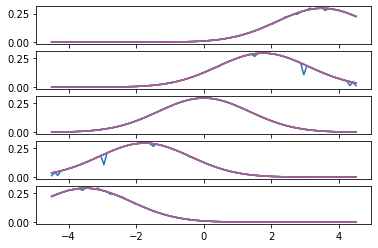

In [26]:
# PPC Probabilities Compuation Plotter

def mean_plotter():
    fig, axes = plt.subplots()
        
    xs = np.linspace(-5*sig_m, 5*sig_m, 100)
    
    ys = prob_mean(xs)
    axes.plot(xs, ys)

def prob_b1_given_mean_3_plotter():
    fig, axes = plt.subplots(3, 1)
    
    sig_b1 = sig[cluster_size]
    means = [-2*sig_b1, 0 , 2*sig_b1]
    
    xs = np.linspace(-5*sig_b1, 5*sig_b1, 100)
    
    for i in range(len(means)):
        ys = prob_b1_given_mean_3(xs, means[i])
        axes[i].plot(xs, ys)
        
def prob_b1_given_s1_4_plotter():
    fig, axes = plt.subplots(5, 1)
    
    sig_b1 = sig[cluster_size]
    sig_s1 = sig[0]
    s1s = [-2*sig_s1, -1*sig_s1, 0, 1*sig_s1, 2*sig_s1]
    
    xs = np.linspace(-3*sig_b1, 3*sig_b1, 100)
    
    for i in range(len(s1s)):
        ys1 = np.zeros(xs.shape)
        ys2 = np.zeros(xs.shape)
        ys3 = np.zeros(xs.shape)
        ys4 = np.zeros(xs.shape)
        ys5 = np.zeros(xs.shape)
        for j, x in enumerate(xs):
            ys1[j] = prob_b1_given_s1_4_v1(x, s1s[i])
            ys2[j] = prob_b1_given_s1_4_v2(x, s1s[i])
            ys3[j] = prob_b1_given_s1_4_v3(x, s1s[i])
            ys4[j] = prob_b1_given_s1_4_v4(x, s1s[i])
            ys5[j] = prob_b1_given_s1_4_v5(x, s1s[i])
            
        print(
            np.sum(ys1) * (xs[-1] - xs[0]) / len(xs),
            np.sum(ys2) * (xs[-1] - xs[0]) / len(xs),
            np.sum(ys3) * (xs[-1] - xs[0]) / len(xs),
            np.sum(ys4) * (xs[-1] - xs[0]) / len(xs),
            np.sum(ys5) * (xs[-1] - xs[0]) / len(xs),
        )
            
        axes[i].plot(xs, ys1)
        axes[i].plot(xs, ys2)
        axes[i].plot(xs, ys3)
        axes[i].plot(xs, ys4)
        axes[i].plot(xs, ys5)

        

        
prob_b1_given_s1_4_plotter()
    

In [5]:
# convert scw.list into pointing array

import numpy as np
import astropy.io.fits as fits
from astropy.table import Table
import astropy.time as at
from datetime import datetime
from PointingClusters import save_clusters
from IntegralPointingClustering import ClusteredQuery


with open("scw.list","r") as scw_file:
    scws = []
    with fits.open("crab_data/1667/pointing.fits") as file:
        tab = Table.read(file[1])
        for line in scw_file:
            scw = line[9:21]
            pointing_fits_info = tab[tab["PTID_ISOC"]==scw[:8]]
            t = at.Time(f'{pointing_fits_info["TSTART"][0]+2451544.5}', format='jd').iso[:-4]
            y, m, d, h, mi, s = int(t[:4]), int(t[5:7]), int(t[8:10]), int(t[11:13]), int(t[14:16]), int(t[17:19])
            tstart = datetime(y, m, d, h, mi, s)
            rax, decx= pointing_fits_info["RA_SPIX", "DEC_SPIX"].as_array()[0]
            
            scws.append(np.array([scw, rax, decx, tstart]))
            
    scws = np.array(scws)
    
cq = ClusteredQuery(
    scws,
    angle_weight=0.,
    time_weight=5.,
    max_distance=1.,
    min_ang_distance=1.5,
    max_ang_distance=7.5,
    cluster_size_range = (2,2),
    failed_improvements_max=3,
    suboptimal_cluster_size=1,
    close_suboptimal_cluster_size=1
).get_clustered_scw_ids()

pointings = []
for size in range(2, 3):
    for cluster in cq[size]:
        pointings.append(tuple([(i, f"crab_data/{i[:4]}") for i in cluster]))
pointings = tuple(pointings)

folder = "orbit_1667_spimodfit_scws"

save_clusters(pointings, folder)


In [2]:
# quartic root

import matplotlib.pyplot as plt
import math
import numpy as np

def quartic_root(A, B, C, D, E):
    alpha = -3 * B**2 / (8 * A**2) + C/A
    beta = B**3 / (8 * A**3) - B * C / (2 * A**2) + D/A
    gamma = -3 * B**4 / (256 * A**4) + C * B**2 / (16 * A**3) - B * D / (4 * A**2) + E / A
    
    if beta == 0.:
        s1 = (alpha**2 - 4*gamma)**0.5
        s2 = ((-alpha + s1) / 2)**0.5
        x = -B/(4*A) + s2
        return x
    
    P = -(alpha**2)/12 - gamma
    Q = -(alpha**3)/108 + alpha*gamma/3 - (beta**2) / 8
    R = -Q/2 + (Q**2 / 4 + P**3 / 27)**0.5
    U = R**(1/3)
    if U == 0.:
        y = -5/6*alpha - (Q**(1/3))
    else:
        y = -5/6*alpha + U - P/(3*U)
    W = (alpha + 2*y)**0.5
    
    s1 = 2*beta/W
    s2 = (-(3*alpha + 2*y + s1))**0.5
    s3 = (W + s2) / 2
    x = -B / (4*A) + s3
    return x

In [12]:
quartic_root(-20.144230141415672, -10.332401583717097, 749.272358187044, 2301.1616043142335, 1578.436366036694)

(7.145137971906084-1.6766410874710565e-18j)

In [17]:
def b_maxL_4(m, t, C):
    t_t = np.sum(t)
    C_ = np.zeros(4)
    m_plus = np.zeros(4)
    m_cross = np.zeros(4)
    m_dot = np.zeros(4)
    
    for i in range(4):
        C_[i] = C[i] - t[i] * m[i]
        m_plus[i] = m[(i+1) % 4] + m[(i+2) % 4] + m[(i+3) % 4]
        m_cross[i] = (m[(i+1) % 4] * m[(i+2) % 4]
                      + m[(i+2) % 4] * m[(i+3) % 4]
                      + m[(i+3) % 4] * m[(i+1) % 4])
        m_dot[i] = m[(i+1) % 4] * m[(i+2) % 4] * m[(i+3) % 4]
        
    A = -t_t.item()
    B = np.sum(C_ - t * m_plus).item()
    C = np.sum(C_ * m_plus - t * m_cross).item()
    D = np.sum(C_ * m_cross - t * m_dot).item()
    E = np.sum(C_ * m_dot).item()
    
    # print(A,B,C,D,E)
    
    alpha = -3 * B**2 / (8 * A**2) + C/A
    beta = B**3 / (8 * A**3) - B * C / (2 * A**2) + D/A
    gamma = -3 * B**4 / (256 * A**4) + C * B**2 / (16 * A**3) - B * D / (4 * A**2) + E / A
    
    if beta == 0.:
        s1 = (alpha**2 - 4*gamma)**0.5
        s2 = ((-alpha + s1) / 2)**0.5
        x = -B/(4*A) + s2
        return x
    
    P = -(alpha**2)/12 - gamma
    Q = -(alpha**3)/108 + alpha*gamma/3 - (beta**2) / 8
    R = -Q/2 + (Q**2 / 4 + P**3 / 27)**0.5
    U = R**(1/3)
    if U == 0.:
        y = -5/6*alpha - (Q**(1/3))
    else:
        y = -5/6*alpha + U - P/(3*U)
    W = (alpha + 2*y)**0.5
    
    s1 = 2*beta/W
    s2 = (-(3*alpha + 2*y + s1))**0.5
    s3 = (W + s2) / 2
    x = -B / (4*A) + s3
    return x.real
    

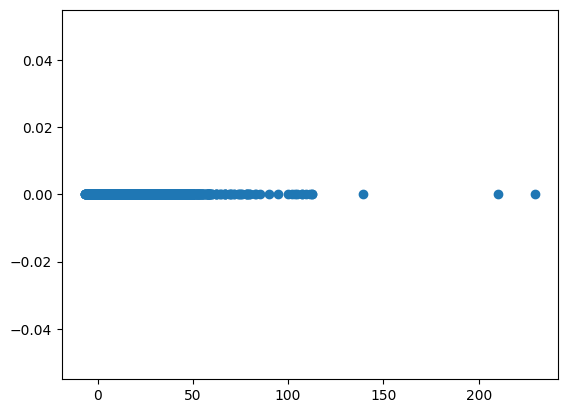

In [18]:
# b_maxl_4 tester
res = []

for i in range(100000):
    m = np.random.random(4) * 10
    t = np.random.random(4) * 10
    C = np.random.random(4) * 100
    
    res.append(b_maxL_4(m, t, C))
    
plt.scatter([i.real for i in res], [i.imag for i in res])

-0.002419432406213673 328.4167336591813 30.581394336596986 92.33436282645096 370.06679559099564 135741.32433394087 -4.97781741087249
-0.0006417204079411931 240.36756980397183 -297.6800538266573 -228.0812799130336 81.0339501403796 (374566.20063040097+8.21100664341263e-27j) (2102.0038811617123-2.7690230815135403e-13j)
-0.004201386158740661 -372.8498086483811 -144.53879866595253 -201.13093884564103 -19.86373154500967 (-0.1452607999126485+0.7000881309888265j) (-1.3491680326185254-0.00014285282406945043j)
0.008645912093015795 -438.5045411596967 -96.37837600535516 -228.02232193731908 -460.6160536213556 50718.35531022401 -3.350407662872385
0.0001258145736642291 -368.67328741445925 292.8827294132702 -109.78312368111034 135.16703983169964 2930290.003193867 3236.82488634211
33.96298316434297 69.56653122525506 -191.93309800250103 -234.2033070878755 -210.33239468290134 (1.389894873088009-0.027421174940243716j) (-593.4653616177065+6.217248937900877e-15j)
-54.82293796481099 42.51828012353826 443.623

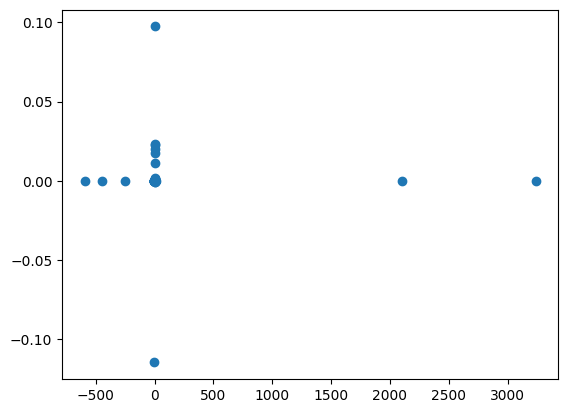

In [3]:
# quartic root tester

res = []
for i in range(1000000):
    arg = np.random.random(5)*1000-500
    A = float(arg[0])
    B = float(arg[1])
    C = float(arg[2])
    D = float(arg[3])
    E = float(arg[4])
    x = quartic_root(A, B, C, D, E)

            
    res.append(
        (A*x**4 + B*x**3 + C*x**2 + D*x + E)
    )
    if abs(res[-1]) > 1.:
        print(A, B, C, D, E, x, res[-1])
plt.scatter([i.real for i in res], [i.imag for i in res])

In [ ]:
# number of scws in crab FOV per revolulution

from IntegralQuery import SearchQuery, IntegralQuery, Filter, Range
from astropy.coordinates import SkyCoord

p = SkyCoord(83.6333, 22.0144, frame="icrs", unit="deg")
searchquerry = SearchQuery(position=p, radius="5 degree",)
cat = IntegralQuery(searchquerry)
f = Filter(SCW_TYPE="POINTING")
scw_ids_all = cat.apply_filter_on_revolutions(f)
for orbit, count in scw_ids_all.items():
    print(orbit, count)

In [ ]:
# create fits file with only some rows

from astropy.io import fits
t = fits.open('sec_source_test.fits.gz')
tbdata = t[1].data
mask = [False for i in range(len(tbdata))]
mask[0] = True
mask[1] = True
newtbdata = tbdata[mask]
hdu = fits.BinTableHDU(data=newtbdata, name="SPI.-SRCL-CAT")
hdu.writeto('new_sec_source_test.fits.gz')